In [1]:
using Test
using StatsBase
using Distributions
using Plots
using FFTW


(process:6744): GLib-GIO-WARNING **: 18:25:17.342: Unexpectedly, UWP app `D5BE6627.UltraZipOpener_2.0.6.0_neutral__9pm2v9747qaaa' (AUMId `D5BE6627.UltraZipOpener_9pm2v9747qaaa!App') supports 127 extensions but has no verbs

(process:6744): GLib-GIO-WARNING **: 18:25:17.696: Unexpectedly, UWP app `KDEe.V.Okular_22.801.1132.0_x64__7vt06qxq7ptv8' (AUMId `KDEe.V.Okular_7vt06qxq7ptv8!KDEe.V.Okular') supports 5 extensions but has no verbs

(process:6744): GLib-GIO-WARNING **: 18:25:17.746: Unexpectedly, UWP app `Clipchamp.Clipchamp_2.5.0.0_neutral__yxz26nhyzhsrt' (AUMId `Clipchamp.Clipchamp_yxz26nhyzhsrt!App') supports 41 extensions but has no verbs


# Empirical distribution

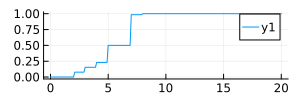

In [2]:
observations = [2.1, 3, 4, 5, 7, 8]
weights = Weights([1, 1, 1, 3.5, 6.3, 0.2])
empirical_distribution = ecdf(observations; weights)
xs = [i for i in 0:0.1:20]
ys = [empirical_distribution(x) for x in xs]
plot(xs,ys, size = (300, 100))

# Convolution of two distributions, FFT

In [3]:
function slow_convolution(v_1, v_2)
    for x in base_points_1
        l = div(x, step)
        tot = 0
        for i in 0:(l-1)
            tot += v_1[i + 1] * v_2[l-i]
        end
        push!(convolution, tot)
    end
    return convolution
end

slow_convolution (generic function with 1 method)

In [4]:
function fft_conv(d_1, d_2, limit)
    q = max(quantile(d_1, 1-limit), quantile(d_2, 1-limit))
    print(q)
    grid = 0:1:round(q)
    vector_values_1 = [pdf(d_1, x) for x in grid]
    vector_values_2 = [pdf(d_2, x) for x in grid]
    vector_conv = real(ifft(fft(vector_values_1).*fft(vector_values_2)))
    weights = Weights(vector_conv)
    return ecdf(grid; weights)
end

fft_conv (generic function with 1 method)

2000

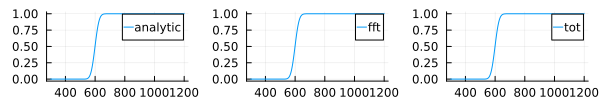

In [5]:
# standard convolution
b_1, b_2 = Binomial(1000, 0.2), Binomial(2000, 0.2)
cv_analytic = convolve(b_1, b_2)
cv_fft = fft_conv(b_1, b_2, 1e-30)
xs_test = 300:1200
p_analytic = plot(xs_test, [cdf(cv_analytic, x) for x in xs_test])
p_fft = plot(xs_test, [cv_fft(x) for x in xs_test])
p_tot = plot(xs_test, [cdf(Binomial(3000, 0.2), x) for x in xs_test])
plot(p_analytic, p_fft, p_tot, layout = (1, 3), size = (600, 100), label=["analytic" "fft" "tot"])

14881.002675202342

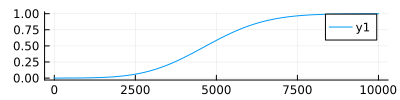

In [6]:
stp = 25
base_points = 0:stp:10000
conv = fft_conv(Gamma(100, 100), Gamma(80, 120), 0.00001)
plot(base_points, [conv(x) for x in base_points], size = (400, 100))

# Frequency-severity model

In [7]:
struct FrequencySeverity
    frequency
    severity
end

In [8]:
function StatsBase.rand(fs::FrequencySeverity)::Real
    tot = 0
    f = rand(fs.frequency)
    if f == 0 return 0 end
    for i in 1:f
        tot += rand(fs.severity)
    end
    return tot
end

function StatsBase.rand(fs::FrequencySeverity, n::Int)
    return [StatsBase.rand(fs) for x in 1:n]
end

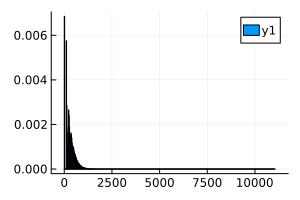

In [9]:
example_frequency = Poisson(2)
example_threshold = 1e2
example_severity = Pareto(3, example_threshold)
ex_d = FrequencySeverity(example_frequency, example_severity)
draws = rand(ex_d, 100000)
histogram(draws, norm = true, size = (300, 200))

### Define moment-generating function for complex values

In [10]:
function Distributions.mgf(d::Poisson, t::Complex)
    λ = rate(d)
    return exp(λ * (exp(t) - 1))
end

In [11]:
α = 2
θ = 300
λ = 4
fs = FrequencySeverity(Poisson(λ), Pareto(α, θ))
nr_steps_approx = 1200
e_end = θ * 5
grid = θ:1:e_end
nr_steps = length(grid)
fft_severity = fft([pdf(fs.severity, x) for x in grid])
convolution_fs = real(ifft([mgf(fs.frequency, log(fft_severity[i])) for i in 1:nr_steps]))
[exp(rate(fs.frequency) * (fft_severity[i] - 1)) for i in 1:nr_steps]

1201-element Vector{ComplexF64}:
    0.8636930725321473 + 0.0im
 -0.002622997345699764 - 0.1391352971978784im
  0.006738516015327399 - 0.054739346521995885im
  0.012593807577205454 - 0.03367864778663824im
  0.015072819872030541 - 0.024459532214591084im
  0.016296580074059618 - 0.019268153901981236im
  0.016979657993024682 - 0.015922493736302678im
   0.01739674674431349 - 0.013579515771548506im
  0.017669081537534038 - 0.011843869978450475im
  0.017856315315922813 - 0.01050489242499797im
   0.01799039838550408 - 0.009439717720180393im
  0.018089636377999492 - 0.008571704014184832im
  0.018165106232642975 - 0.007850491453638383im
                       ⋮
  0.018165106232642975 + 0.007850491453638385im
  0.018089636377999492 + 0.00857170401418483im
   0.01799039838550408 + 0.009439717720180395im
  0.017856315315922813 + 0.01050489242499797im
   0.01766908153753403 + 0.01184386997845047im
  0.017396746744313494 + 0.013579515771548503im
   0.01697965799302468 + 0.01592249373630268im
  0.016

In [12]:
observation_plot = plot()
plot!(grid[2:end], convolution_fs)
display(observation_plot)

LoadError: BoundsError: attempt to access 1200-element StepRange{Int64, Int64} at index [1:1201]